In [20]:
from copy import deepcopy

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from cmocean.cm import thermal, thermal_r
from matplotlib.colors import Normalize
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

from inlifesim.bootstrapping import EvaluateBootstrapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Create data for Lookup Table

The following code is used to bootstrap the test statistic to generate data for

```python
import numpy as np

from inlifesim.statistics import get_sigma_lookup

# set all parameters
params = {
    "n_cpu": 70,  # number of CPU cores to use for parallel processing
    "n_dof": 36,  # number of degrees of freedom of the IMB distribution
    "n_sigma": 10000,  # number of sigma values to calculate
    "B": int(1e10),  # number of bootstap samples
    "N": 50,  # number of noise samples per measurement
    "B_per": int(
        1e7
    ),  # number of samples per parallel process (optimize RAM usage)
    # values for the variance of the IMB noise
    "sigma_imb": np.array(
        (0.0, 1e-3, 1e-2, 1e-1, 0.2, 0.5, 0.7, 1.0,
         1.5, 2.0, 3.0, 5.0, 1e2, 1e3, 1e4, 1.0),
        dtype=float,
    ),
    # values for the variance of the Gaussian noise
    "sigma_gauss": np.array(
        (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                             1.0, 1.0, 1.0, 1.0, 1.0, 0.0),
        dtype=float),
}

for i, (sg, si) in enumerate(zip(params["sigma_gauss"], params["sigma_imb"])):
    print(
        "Working on sigma_gauss =",
        sg,
        "sigma_imb =",
        si,
        "(",
        i,
        "/",
        len(params["sigma_gauss"]),
        ")",
    )

    sigma_want, sigma_get = get_sigma_lookup(
        sigma_gauss=sg,
        sigma_imb=si,
        B=params["B"],
        N=params["N"],
        B_per=params["B_per"],
        n_sigma=params["n_sigma"],
        n_cpu=params["n_cpu"],
        nconv=params["n_dof"],
        verbose=True,
        parallel=True,
    )

    print("Saving the results...", end=" ", flush=True)
    results = np.concatenate((sigma_want, sigma_get))

    sg_str = str(sg).replace(".", "-")
    si_str = str(si).replace(".", "-")

    # save the results
    np.save(f"output_path/sigma_lookup_{sg_str}_{si_str}.npy", results)

    print("[Done]")

```

In [2]:
# Setup for plotting

#Direct input
plt.rcParams['text.latex.preamble']=r'\usepackage{lmodern} \usepackage{amsmath}'

#Options
params = {'text.usetex' : True,
          'font.size' : 8,
          'font.family' : 'lmodern',
          # 'text.latex.unicode': True,
          }
plt.rcParams.update(params)

# 2. Evaluate the Bootstrapping
In this step, the lookup table is created by interpolating for small significances and extrapolating to higher significances.

In [3]:
root = ('data/')

paths = [root + '1e10_v3/']

ev = EvaluateBootstrapping(verbose=False,
                           paths=paths,
                           bootstrap_properties={'B': int(1e10),
                                                 'N': 50,
                                                 'log_sampling_max': 3})

print('Extrapolating logistic parameters', end='')
ev.extrapolate_logistic_parameters(sigma_actual_shape=(1.8, 7.8, 200),
                                   start_fit_at_sigma=[3, 3, 5, 2.5],
                                   end_fit_at_sigma=[5, 5, 7, 7.5],
                                   polynomial_order=[1, 1, 1, 2])
print('[Done]')

print('Creating large lookup table', end='')
ev.create_lookup_table(sigma_actual_shape=(0.2, 7., 200),
                            sigma_analytical_shape=(0, 8, 1000),
                            sigma_ratio_shape=(-1., 0.75, 1000),
                            n_analytical=400,
                       table_name='large',
                       crit_value=6)
print('[Done]')

print('Creating large lookup table', end='')
ev.create_lookup_table(sigma_actual_shape=(0.07, 0.25, 200),
                        sigma_analytical_shape=(0, 0.25, 1000),
                        sigma_ratio_shape=(-1., 0.75, 1000),
                        n_analytical=400,
                       table_name='small',
                       crit_value=0.2,
                       initial_guess=[-0.29, 5.26, 0.08, 0.07],
                       update_guess=True,
                       make_n_plots=10)
print('[Done]')

print('Extrapolating lookup table', end='')
ev.create_extrapolated_lookup_table(sigma_actual_shape=(5, 30, 1000),
                                    sigma_ratio_shape=(-1., 0.75, 1000),
                                    sigma_analytical_shape=(3, 30, 1000))
print('[Done]')

Extrapolating logistic parameters

/Users/fdannert/Documents/projects/InLIFEsim/InLIFEsim/inlifesim/bootstrapping.py:338: RuntimeWarning: divide by zero encountered in scalar divide
  rat_bes_gaus.append(si / sg)


[Done]
Creating large lookup table[Done]
Creating large lookup table[Done]
Extrapolating lookup table[Done]
[Done]


# 3. Create Figure 4

In [4]:
# add points for detection and characterization of Earth twin, created using the final table
scenario = {'detection': {'sig': 1.57,
                           'ratio': 0.7,
                          't_ratio': 0.999,
                          'ms': 'v'},
             'characterization': {'sig': 9.6,
                                  'ratio': 0.95,
                                  't_ratio': 0.92,
                                  'ms': '^'}}

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/3567877727.py:20: RuntimeWarning: divide by zero encountered in log10
  if np.log10(si/sg) == -np.inf:
/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/3567877727.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  if np.log10(si/sg) == -np.inf:
/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/3567877727.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  elif np.log10(si/sg) == np.inf:


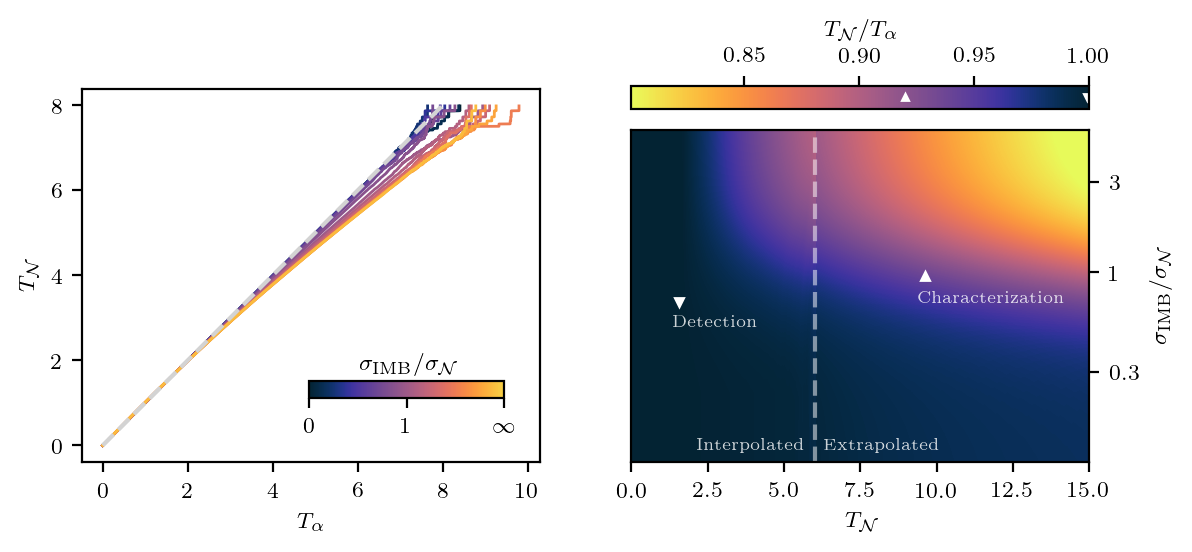

In [5]:
fig, ax = plt.subplots(
    ncols=2,
    figsize=(6.5, 2.7),
    dpi=200,
    gridspec_kw={
        'width_ratios': [1, 1],
        # 'wspace': 0.5,
    }
)

dax = ax[0]

lw = {'medium': 1,
      'small': 0.5,}

# extract N colors from the thermal colormap
colors = thermal(np.linspace(0, 0.85, len(ev.sigma_gauss)))

for sg, si, c in zip(ev.sigma_gauss, ev.sigma_bessel, colors):
    if np.log10(si/sg) == -np.inf:
        label='0'
    elif np.log10(si/sg) == np.inf:
        label='$\infty$'
    elif int(np.log10(si/sg)) == 0 and np.log10(si/sg) < 0:
        label=f'{np.round(si/sg, 2)}'
    elif int(np.log10(si/sg)) == 0 and np.log10(si/sg) >= 0:
        label=f'{int(np.round(si/sg, 0))}'
    else:
        label=f'$10^{{{int(np.log10(si/sg))}}}$'
    dax.plot(ev.sigma_want_get[(sg, si)][1], ev.sigma_want_get[(sg, si)][0],
             # format the labels in scientific notation
             #    label=label,
            color=c,
             lw=lw['medium']
            )

dax.plot(ev.sigma_want_get[(ev.sigma_gauss[1], ev.sigma_bessel[1])][0], ev.sigma_want_get[(ev.sigma_gauss[1], ev.sigma_bessel[1])][0], color='lightgray', ls='--', alpha=1)

# in the bottom left of the plot, I want a small colorbar replacing the labels of the individual lines
cbar_ax = fig.add_axes([0.3, 0.23, 0.15, 0.03])
cbar = matplotlib.colorbar.ColorbarBase(ax=cbar_ax, cmap=thermal, orientation='horizontal')

cbar_ax.set_xlim(0, 0.85)

pos_ticks = list(np.array([0, 8, 16]) / (len(ev.sigma_gauss)-1) * 0.85)
ticks = ['0', '1' , r'$\infty$']

# add a label of the colorbar to the right of the colorbar
cbar.set_label(r'$\sigma_{\mathrm{IMB}} / \sigma_{\mathcal{N}}$')
# make the label appear on top of the colorbar
cbar_ax.xaxis.set_label_position('top')


cbar.set_ticks(pos_ticks)
cbar.set_ticklabels(ticks)

dax.set_xlabel(r'$T_\alpha$')
dax.set_ylabel(r'$T_\mathcal{N}$')

# dax.set_ylim(dax.get_xlim())

dax.set_aspect('equal', 'box')
dax.set_anchor('S')

ax = ax[1]

ta_max = 15

idx_col = np.argmin(np.abs(np.linspace(5, 30, 1000) - ta_max))
vmin = ev.lookup['extrapolation_ratio'][:, idx_col].min()

ax.imshow(ev.lookup['small_ratio'], cmap=thermal_r, origin='lower', extent=(0.07, 0.25, -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)
im = ax.imshow(ev.lookup['extrapolation_ratio'], cmap=thermal_r, origin='lower', extent=(3, 30, -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)

cbar = plt.colorbar(im, ax=ax, location='top')
cbar.set_label(r'$T_\mathcal{N} / T_\alpha$')

large_ratio = deepcopy(ev.lookup['large_ratio'])
ts_alpha = np.linspace(ev.shape['large_ta'][0], ev.shape['large_ta'][1], large_ratio.shape[0])
idx = {'large': np.argmin(np.abs(ts_alpha - ev.crit_value['large'])),
       'small': np.argmin(np.abs(ts_alpha - ev.crit_value['small']))}

idx['large_co'] = ts_alpha[idx['large']]
idx['small_co'] = ts_alpha[idx['small']]

large_ratio = large_ratio[:, idx['small']:idx['large']]

ax.imshow(large_ratio, cmap=thermal_r, origin='lower', extent=(idx['small_co'], idx['large_co'], -1, 0.75), aspect='auto', vmin=vmin, vmax=1.0)

# ax.contour(large_ratio, origin='lower', extent=(idx['small_co'], idx['large_co'], -1, 0.75), aspect='auto', colors='w', levels=[0.95], lw=0.5, alpha=0.5)
# ax.contour(ev.lookup['extrapolation_ratio'], origin='lower', extent=(3, 30, -1, 0.75), aspect='auto', colors='w', levels=[0.95], lw=0.5, alpha=0.5)

ax.axvline(ev.crit_value['large'], color='w', ls='--', alpha=0.5)
ax.set_facecolor(thermal(0))

ax.text(ev.crit_value['large']+0.3, -0.95, 'Extrapolated', ha='left', va='bottom', color='w', fontsize=6, alpha=0.8)
ax.text(ev.crit_value['large']-0.3, -0.95, 'Interpolated', ha='right', va='bottom', color='w', fontsize=6, alpha=0.8)

ax.plot(scenario['detection']['sig'], np.log10(scenario['detection']['ratio']), 'v', color='w', ms=3)
cbar.ax.plot(scenario['detection']['t_ratio'], 0.5, 'v', color='w', ms=2)  # Set black edgecolor for detection t_ratio marker
ax.text(scenario['detection']['sig']-0.2, np.log10(scenario['detection']['ratio']-0.1), s='Detection', c='w', ha='left', va='top', fontsize=6, alpha=0.8)

ax.plot(scenario['characterization']['sig'], np.log10(scenario['characterization']['ratio']), '^', color='w', ms=3)
cbar.ax.plot(scenario['characterization']['t_ratio'], 0.5, '^', color='w', ms=2)
ax.text(scenario['characterization']['sig']-0.2, np.log10(scenario['characterization']['ratio']-0.15), s='Characterization', c='w', ha='left', va='top', fontsize=6, alpha=0.8)

ax.set_xlim(0., 15)

yticks = np.log10(np.array([3e-1, 1, 3]))
ytick_labels = [r'$0.3$', r'$1$', r'$3$']
ax.set_yticks(yticks, ytick_labels)

# y ticks and lable on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

ax.set_ylabel(r'$\sigma_\mathrm{IMB} / \sigma_\mathcal{N}$')
ax.set_xlabel(r'$T_\mathcal{N}$')

plt.show()

# 4. Create Figure 10

In [14]:
def logistic(x, x0, k, ymin, ymax):
    return (ymax - ymin) / (1 + np.exp(-k*(x - x0))) + ymin

def inverse_logistic(y, x0, k, ymin, ymax):
    return np.log((y - ymin) / (ymax - y) - 1) / k + x0

def get_interest_area(k, rt):
    return -np.log(1 / rt - 1)/k

def add_normalized_line_collection(ax, cmap, linewidth=3, linestyle='-'):
    norm = Normalize(vmin=0., vmax=1.)
    t = np.linspace(0, 1, 100)  # Smooth gradient
    lc = LineCollection([np.column_stack([t, t * 0])], cmap=cmap, norm=norm, linewidth=linewidth, linestyle=linestyle)
    lc.set_array(np.linspace(0., 1, len(t)))  # Ensure this spans 0 to 1 for correct normalization
    # ax.add_collection(lc)  # Add the LineCollection to the axis
    return lc

class HandlerColorLineCollection(HandlerLineCollection):
    def __init__(self, cmap, **kwargs):
        self.cmap = cmap
        super().__init__(**kwargs)

    def create_artists(self, legend, artist, xdescent, ydescent, width, height, fontsize, trans):
        x = np.linspace(0, width, self.get_numpoints(legend) + 1)
        y = np.zeros(self.get_numpoints(legend) + 1) + height / 2. - ydescent
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=self.cmap, transform=trans)
        lc.set_array(x)
        lc.set_linewidth(2)
        return [lc]

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/239787911.py:1: RuntimeWarning: divide by zero encountered in divide
  sigma_ratios = deepcopy((ev.sigma_bessel / ev.sigma_gauss)[:-1])
/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/239787911.py:16: RuntimeWarning: divide by zero encountered in log10
  y = logistic(np.log10(sr), y1, x0, k, y0)


chosen inset x/ylim & width/height skew aspect w.r.t. main axes!


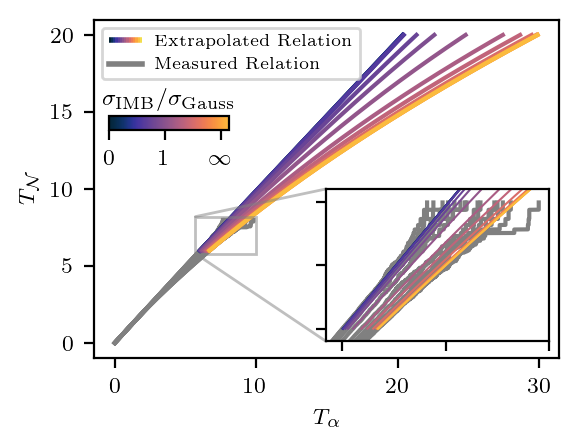

In [18]:
sigma_ratios = deepcopy((ev.sigma_bessel / ev.sigma_gauss)[:-1])
sigma_actual = np.linspace(6, 20, 1000)

sigma_analytical = []

for sr in sigma_ratios:
    sig_anas = []
    for sa in sigma_actual:
        # retrieve the fit parameters extrapolation
        y1 = np.polyval(ev.logistic_extrapolation[0], sa)
        x0 = np.polyval(ev.logistic_extrapolation[1], sa)
        k = np.polyval(ev.logistic_extrapolation[2], sa)
        y0 = np.polyval(ev.logistic_extrapolation[3], sa)

        # calculate the logistic function
        y = logistic(np.log10(sr), y1, x0, k, y0)

        sig_anas.append(y)
    sigma_analytical.append(sig_anas)

sigma_analytical = np.array(sigma_analytical)

fig, ax = plt.subplots(figsize=(3., 2.2), dpi=200)

# extract N colors from the thermal colormap
colors = thermal(np.linspace(0, 0.85, len(sigma_ratios)))

sel = True
for sg, si, c in zip(ev.sigma_gauss, ev.sigma_bessel, colors):
    if sel == False:
        label = None
    else:
        label = 'Measured Relation'
        sel = False
    ax.plot(ev.sigma_want_get[(sg, si)][1], ev.sigma_want_get[(sg, si)][0],
            color='gray')

for i, c in enumerate(colors):
    ax.plot(sigma_analytical[i], sigma_actual,
             # format the labels in scientific notation
                # label=f'${sigma_ratios[i]:.2e}$',
            color=c)

# --- COLORBAR ---
cbar_ax = fig.add_axes([0.15, 0.63, 0.2, 0.03])
cbar = matplotlib.colorbar.ColorbarBase(ax=cbar_ax, cmap=thermal, orientation='horizontal')

cbar_ax.set_xlim(0, 0.85)

# make the ticks of the colorbar appear on the top

# cbar_ax.xaxis.set_ticks_position('top')

pos_ticks = list(np.array([0, 7, 14]) / (len(ev.sigma_gauss)-1) * 0.85)
ticks = ['0', '1' , r'$\infty$']

# add a label of the colorbar to the right of the colorbar
cbar.set_label(r'$\sigma_{\mathrm{IMB}} / \sigma_{\mathrm{Gauss}}$')
# make the label appear on top of the colorbar
cbar_ax.xaxis.set_label_position('top')

cbar.set_ticks(pos_ticks)
cbar.set_ticklabels(ticks)

# --- LEGEND ---

# Create color lines for legend
color_line = add_normalized_line_collection(ax, cmap=thermal, linewidth=4)
gray_line = Line2D([0], [0], color='gray', lw=2)

# Existing legend handles and labels
handles = []
labels = []

handles.append(color_line)
labels.append('Extrapolated Relation')

handles.append(gray_line)
labels.append('Measured Relation')

ax.legend(
    handles,
    labels,
    handler_map={color_line: HandlerColorLineCollection(cmap=thermal, numpoints=len(sigma_ratios))},
    loc="upper left",
    frameon=True,
    fontsize=6
)

# ---- INSET ---
inset_ax = ax.inset_axes(
   [0.5, 0.05, 0.48, 0.45],  # [x, y, width, height] w.r.t. axes
    xlim=[5.7, 10], ylim=[5.8, 8.2], # sets viewport & tells relation to main axes
    xticklabels=[], yticklabels=[]
)

# add plot content
for sg, si, c in zip(ev.sigma_gauss, ev.sigma_bessel, colors):
    if sel == False:
        label = None
    else:
        label = 'Measured Relation'
        sel = False
    inset_ax.plot(ev.sigma_want_get[(sg, si)][1], ev.sigma_want_get[(sg, si)][0],
            color='gray')

for i, c in enumerate(colors):
    inset_ax.plot(sigma_analytical[i], sigma_actual,
             # format the labels in scientific notation
                # label=f'${sigma_ratios[i]:.2e}$',
            color=c,
                  lw=0.75)

# make background of inset axis black
# inset_ax.set_facecolor('black')


# add zoom leaders
ax.indicate_inset_zoom(inset_ax, edgecolor="gray")

if not np.isclose(inset_ax._get_aspect_ratio(), ax._get_aspect_ratio()):
    print("chosen inset x/ylim & width/height skew aspect w.r.t. main axes!")


ax.set_xlabel(r'$T_\alpha$')
ax.set_ylabel(r'$T_\mathcal{N}$')

plt.show()

# 5. Create Figure 9

/var/folders/rs/chvp5qfj3j76n4gdp708g4vc0000gn/T/ipykernel_2107/3901033937.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  rat_bes_gaus.append(si/sg)


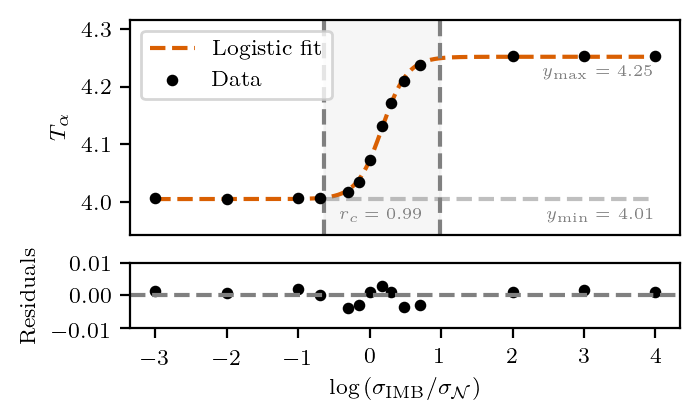

In [21]:
sig_actual = 4
guess = None
bounds = (-np.inf, np.inf)

sig_analytical = []
rat_bes_gaus = []

for sg, si in zip(ev.sigma_gauss, ev.sigma_bessel):
    sig_analytical.append(np.interp(sig_actual,
                                    ev.sigma_want_get[(sg, si)][0],
                                    ev.sigma_want_get[(sg, si)][1]))
    rat_bes_gaus.append(si/sg)

ratio_sig = np.array((sig_analytical, rat_bes_gaus)).T

# noinspection PyTupleAssignmentBalance
popt, _ = curve_fit(f=logistic,
                    xdata=np.log10(ratio_sig[1:-1, 1]),
                    ydata=ratio_sig[1:-1, 0],
                    p0=guess,
                    bounds=bounds)


x = np.log10(ratio_sig[1:-1, 1])
y = ratio_sig[1:-1, 0]


fig, ax = plt.subplots(nrows=2, figsize=(3.55, 2), height_ratios=[1, 0.3], dpi=200)

x_sample = np.linspace(np.min(x), np.max(x), 1000)
ax[0].plot(x_sample, logistic(x_sample, *popt), '--',
           c='#d95f02', label='Logistic fit')

# Plot the original data (with noise) and the fitted curve
ax[0].scatter(x, y, label='Data', color='k', s=10, zorder=10)

ax[0].set_xticks([])
ax[0].legend(loc='upper left')

ax[1].set_xlabel(r'$\mathrm{log}\left(\sigma_\mathrm{IMB} / \sigma_\mathcal{N}\right)$')
ax[0].set_ylabel(r'$T_\alpha$')

# draw horizontal line at y=0
ax[1].axhline(0, color='gray', ls='--')
# plot residual in lower axis
ax[1].scatter(x, y - logistic(x, *popt),
              color='k',
              label='Data - Logistic',
              s=10,)
ax[1].set_ylim([-0.01, 0.01])
ax[1].set_ylabel('Residuals')

x_ext = get_interest_area(popt[1], 0.99)
# indicate intereste area
ax[0].axvline(popt[0] - x_ext, color='gray', ls='--')
ax[0].axvline(popt[0] + x_ext, color='gray', ls='--')

# ax[0].axvline(popt[0], color='lightgray', ls='--')

ax[0].set_ylim(ax[0].get_ylim()[0]-0.05, ax[0].get_ylim()[1]+0.05)
# fill between with light gray without white spaces above and below
ax[0].fill_betweenx([3, 5], popt[0] - x_ext, popt[0] + x_ext, color='lightgray', alpha=0.2)

ax[0].plot([popt[0] - x_ext, x.max()], [popt[2]]*2, color='gray', ls='--', alpha=0.5)

# print y_min and y_max at the right end of the plot
ax[0].text(x.max(), popt[2]-0.015, r'$y_{\mathrm{min}}$ = ' + str(np.round(popt[2], 2)),
           color='gray', va='top', ha='right',
           fontsize=6)
ax[0].text(x.max(), popt[3]-0.015, r'$y_{\mathrm{max}}$ = ' + str(np.round(popt[3], 2)),
           color='gray', va='top', ha='right',
           fontsize=6)

ax[0].text(popt[0], popt[2]-0.015, r'$r_c = 0.99$',
           color='gray', va='top', ha='center',
           fontsize=6)

plt.show()